#### Covid-19 detection using CNN and transfer-learning techniques on Chest X-Ray Images. 

**Research question**

Which Convolutional Neural Network (CNN) architecture for Machine Learning is the most efficient at 
classifying Chest X-Ray images for Covid-19 patients?

### 1. Libraries import and setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import constants as CONSTANTS
import utilities as UTILS
from enums import (
  ClassificationType,
  CollectionType,
  LabelType,
  ModelType
)
import models as MODELS

UTILS.detect_GPU()

%load_ext tensorboard

✅ GPU detected


### 2. Loading dataset/s

In [2]:
def loadRadiographyDataDictionary():
  def _getFolderName(labelType):
    return {
      LabelType.COVID: "COVID",
      LabelType.NORMAL: "Normal",
      LabelType.PNEUMONIA: "Viral Pneumonia"
    }[labelType]

  def _toModel(labelType):
    metadata = pd.read_excel(CONSTANTS.DATASET_RADIOGRAPHY_ROOT + "/" + _getFolderName(labelType) + ".metadata.xlsx")
    images = []

    for i in range(metadata.shape[0]):
      images.append(CONSTANTS.DATASET_RADIOGRAPHY_ROOT + "/" + _getFolderName(labelType) + "/" + metadata["FILE NAME"].iloc[i] + ".png")

    df_result = pd.DataFrame(images, columns=["image"])

    # 2 class validation override
    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS and labelType == LabelType.PNEUMONIA:
      df_result["label"] = LabelType.COVID.value
    else:
      df_result["label"] = labelType.value

    return df_result

  return {
    LabelType.COVID: _toModel(LabelType.COVID),
    LabelType.NORMAL: _toModel(LabelType.NORMAL),
    LabelType.PNEUMONIA: _toModel(LabelType.PNEUMONIA)
  }

# radiography_data_dict = loadRadiographyDataDictionary()
# radiography_df = flatten_dataframes_dictionary(radiography_data_dict)
# radiography_df.shape[0]
# radiography_df.sample(10)

In [3]:
def loadChestDataDictionary():
  def _getFolderName(labelType):
    return {
      LabelType.COVID: "COVID19",
      LabelType.NORMAL: "NORMAL",
      LabelType.PNEUMONIA: "PNEUMONIA"
    }[labelType]

  def _toModel(labelType):
    images = []

    def _loadCollectionProcedure(collectionType):
      for dirname, _, filenames in os.walk(CONSTANTS.DATASET_CHEST_ROOT + "/" + collectionType.value + "/" + _getFolderName(labelType)):
        for filename in filenames:
          images.append(os.path.join(dirname, filename))

    _loadCollectionProcedure(CollectionType.TEST)
    _loadCollectionProcedure(CollectionType.TRAIN)

    df_result = pd.DataFrame(images, columns=["image"])
    
    # 2 class validation override
    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS and labelType == LabelType.PNEUMONIA:
      df_result["label"] = LabelType.COVID.value
    else:
      df_result["label"] = labelType.value

    return df_result

  return {
    LabelType.COVID: _toModel(LabelType.COVID),
    LabelType.NORMAL: _toModel(LabelType.NORMAL),
    LabelType.PNEUMONIA: _toModel(LabelType.PNEUMONIA)
  }

# chest_data_dict = loadChestDataDictionary()
# chest_df = flatten_dataframes_dictionary(chest_data_dict)
# chest_df.shape[0]
# chest_df.sample(10)

In [4]:
chest_data_dict = loadChestDataDictionary()
chest_df = UTILS.flatten_dataframes_dictionary(chest_data_dict)
# del chest_data_dict, chest_df

print("Chest dataset:")
print(chest_df["label"].value_counts())

Chest dataset:
pneumonia    4273
normal       1583
covid         576
Name: label, dtype: int64


In [5]:
radiography_data_dict = loadRadiographyDataDictionary()
radiography_df = UTILS.flatten_dataframes_dictionary(radiography_data_dict)
# del radiography_data_dict, radiography_df

print("Radiography dataset:")
print(radiography_df["label"].value_counts())

Radiography dataset:
normal       10192
covid         3616
pneumonia     1345
Name: label, dtype: int64


In [6]:
unbalanced_source_dict = UTILS.merge_dataframe_dictionaries(chest_data_dict, radiography_data_dict)
unbalanced_data_df = UTILS.flatten_dataframes_dictionary(unbalanced_source_dict)

# Balance data labels
source_dict = UTILS.merge_dataframe_dictionaries(chest_data_dict, radiography_data_dict)
UTILS.min_count_balance_data_dict(source_dict)

source_df = UTILS.flatten_dataframes_dictionary(source_dict)

print("Source dataset:")
print(source_df["label"].value_counts())

Source dataset:
normal       4192
pneumonia    4192
covid        4192
Name: label, dtype: int64


### 3. Dataset analysis

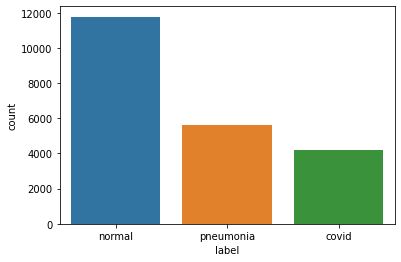

In [7]:
sns.countplot(data=unbalanced_data_df, x="label", order=unbalanced_data_df.label.value_counts().index)
del unbalanced_source_dict, unbalanced_data_df

<AxesSubplot:xlabel='label', ylabel='count'>

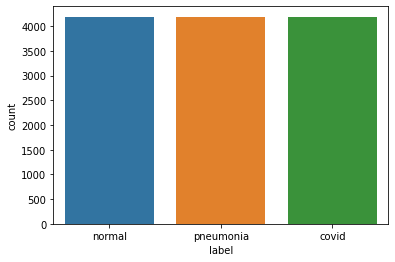

In [8]:
sns.countplot(data=source_df, x="label", order=source_df.label.value_counts().index)

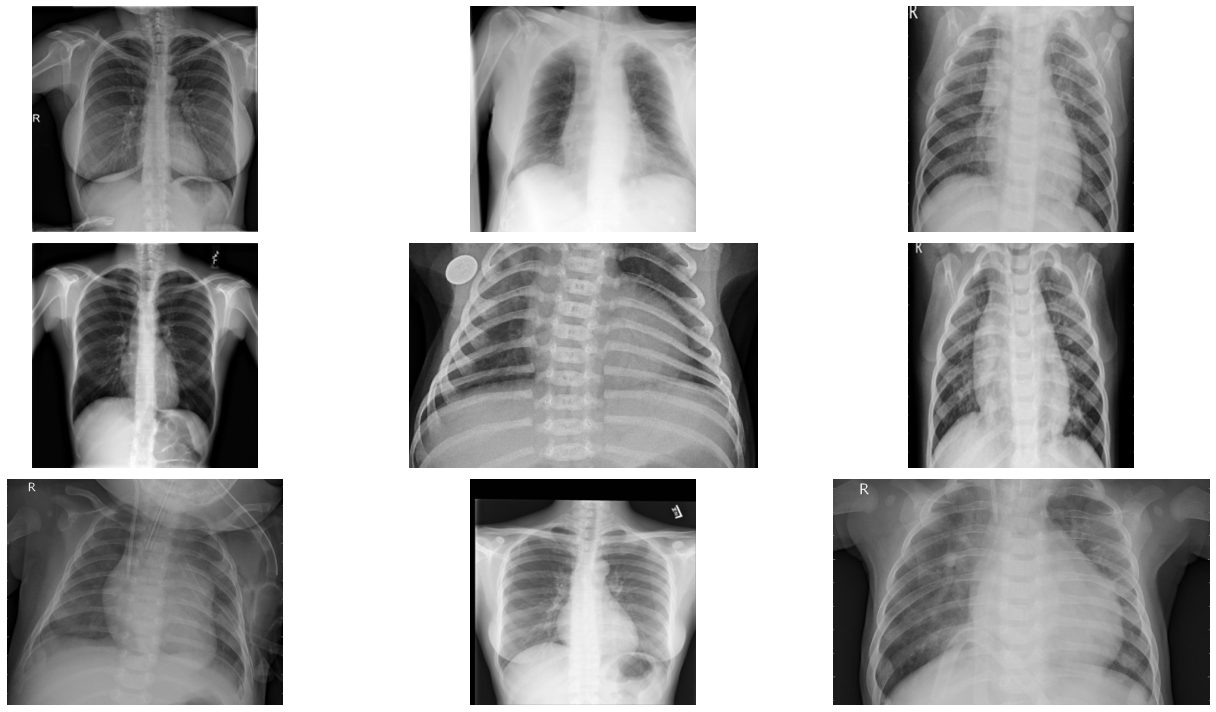

In [9]:
image_samples = list(source_df.sample(9)["image"]) 

plt.figure(figsize=(20, 10))

for i, sample in zip(range(9), image_samples):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(sample)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    
plt.tight_layout()


The dimensions of the image are 299 pixels width and 299 pixels height, one single color channel.
The maximum pixel value is 0.8941 and the minimum is 0.0000
The mean value of the pixels is 0.3203 and the standard deviation is 0.1763


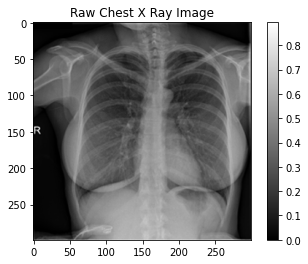

In [10]:
sample_img = plt.imread(image_samples[0])
plt.imshow(sample_img, cmap="gray")
plt.colorbar()
plt.title("Raw Chest X Ray Image")

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

C:\tools\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

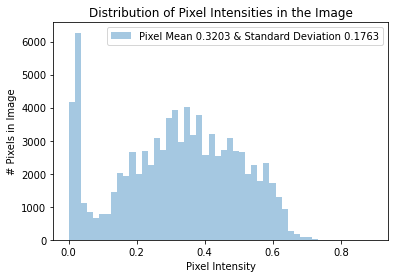

In [11]:
sns.distplot(sample_img.ravel(),
  label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
  kde=False)
plt.legend(loc="upper right")
plt.title("Distribution of Pixel Intensities in the Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("# Pixels in Image")

What if I do an average for the above

### 4. Model building

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
  source_df["image"],
  source_df["label"],
  test_size=CONSTANTS.TEST_SPLIT_SIZE,
  random_state=42
)

train_df = pd.DataFrame({ "image_path": x_train, "label": y_train })
test_df = pd.DataFrame({ "image_path": x_test, "label": y_test })

In [13]:
train_generator = ImageDataGenerator(CONSTANTS.TRAIN_IMAGE_GEN_OPTIONS).flow_from_dataframe(
  train_df,
  x_col="image_path",
  y_col="label",
  target_size=CONSTANTS.INPUT_SIZE,
  batch_size=32,
  shuffle=True,
  class_mode="sparse",
  validate_filenames=True
)

test_generator = ImageDataGenerator(CONSTANTS.TEST_IMAGE_GEN_OPTIONS).flow_from_dataframe(
  test_df,
  x_col="image_path",
  y_col="label",
  target_size=CONSTANTS.INPUT_SIZE,
  batch_size=1,
  shuffle=False,
  class_mode="sparse",
  validate_filenames=True
)

Found 10060 validated image filenames belonging to 3 classes.
Found 2516 validated image filenames belonging to 3 classes.


In [ ]:
# try:
#   del chest_data_dict, chest_df
# except:
#   print("Chest dataset not found")

# try:
#   del radiography_data_dict, radiography_df
# except:
#   print("Radiography dataset not found")

# try:
#   del source_dict, source_df
# except:
#   print("Source dataset not found")

##### Compile

In [ ]:
deep_covid_model = MODELS.get(ModelType.DEEP_COVID)

opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

deep_covid_model.compile(
  optimizer=opt,
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"]
)

##### Train

[RAM optimisation stack overflow](https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch)

In [ ]:
deep_covid_model.fit(
  train_generator,
  epochs=10,
  validation_data=test_generator,
  verbose=1,
  callbacks=[UTILS.get_tensorboard_callback(ModelType.DEEP_COVID)]
)

In [ ]:
# deep_covid_model.save("models/deepCovid2C")

In [14]:
from models import load_my_model

newmodel2 = load_my_model(ModelType.DEEP_COVID, ClassificationType.TWO_CLASS)

In [ ]:
# from tensorflow.keras.models import load_model
# newmodel2 = load_model("models/deepCovid2C")

True value is : normal
Prediction is: [[1.3198483e-06 9.9999869e-01 6.5804301e-16]]
Prediction is: NORMAL


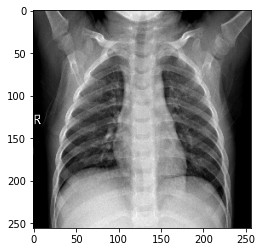

In [51]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

sample = source_df.sample(1)

image_path = sample["image"].iloc[0]
image_label = sample["label"].iloc[0]

print(f'True value is : {image_label}')

image = load_img(image_path, target_size=CONSTANTS.INPUT_SIZE)
img = img_to_array(image)
img = img.reshape((1, 256, 256, 3))

result = newmodel2.predict(img)
print('Prediction is:', result)
result = np.argmax(result, axis=-1)

if result[0] == 0:
    print('Prediction is: COVID')
elif result[0] == 1:
    print('Prediction is: NORMAL')
else:
    print('Prediction is: PNEUMONIA')

# covid, normal, pneumonia
plt.imshow(image) 

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(newmodel2, show_shapes=True)

In [ ]:
plt.rcParams.update({'font.size': 16})
predictions = newmodel2.predict(test_generator)
predictions = np.argmax(predictions,axis=1)
predictions[:15]
cm = confusion_matrix(test_generator.classes, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2'], columns = ['0', '1', '2'])
cm
class_names = ['COVID','NORMAL','VIRAL PNEUMONIA']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_generator.classes, predictions, normalize='true')
def plot_confusion_matrix (cm):
    plt.figure(figsize = (8,8))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt=".2%", 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [ ]:
mobile_net_model = MODELS.get(ModelType.MOBILE_NET_V2)

opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

mobile_net_model.compile(
  optimizer=opt,
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"]
)

In [ ]:
mobile_net_model.fit_generator(
  train_generator,
  epochs=5,
  validation_data=test_generator,
  verbose=1,
  callbacks=[UTILS.get_tensorboard_callback(ModelType.MOBILE_NET_V2)]
)